# 分布式 Logistic 回归模型
最终目的是理解y的分布，p(y=1)=p      
理论上每一个观测yi对应一个pi      
利用观测yi的自变量xi构建和pi的关系，$pi=xi*beta$ 前者（0，1） 后者 R         
这时需要一个映射将R->（0，1）     
logistic选用了sigmoid （可选项）     
需要选择损失函数      
此时选择似然函数（性质好 掌握性质！）     
$P(Y_i=y) = p_i^y_i*(1-p_i)^{1-y_i}$       


Two branches of **methods for classification**:generative modeling/discriminative modeling      
Naive Bayes is a generative classifier;logistic regression is a discrimitive classifier    
A generative model like naive Bayes assigns a class c to a document d by computing a likelihood and a prior
$$ \hat c = \underset{c\in C}{argmax} P(d|c) P(c) $$     
A discriminative model attempts to directly compute $P(c|d)$     

**Components of a probabilistic machine learning classifier**:      
1. A feature represntation of the input.Observation x->a vector of features(x1,x2,...,xn)
2. A classification function that computes $\hat y$.(ex. sigmoid and softmax tools)
3. An objective function for learning, usually involving minimizing error on training examples.(cross-entropy loss function)
4. An algorithm for optimizing the objective function.(gradient descent...)


Logistic regression learns, from a training set, a vector of **weights** and a **bias** term.

Each weight $w_i$ is a real number, and is associated with one of the input features $x_i$. The weight $w_i$ represents how important that input feature to the classification decision.           
The bias term, also called the intercept, is another real number that’s added to the weighted inputs.
The resulting single number z expresses the weighted sum of the evidence for the class.
$$z = \big(\sum_{i=1}^n w_ix_i \big) + b$$
$$ z = w\cdot x + b$$

To create a probability, we’ll pass $z$ through the sigmoid function, $\sigma(z)$.
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

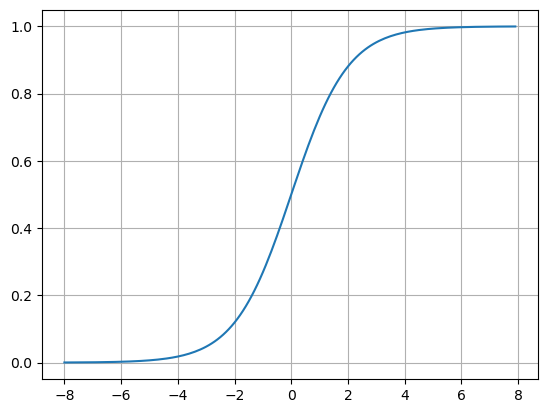

In [10]:
import numpy as np
import matplotlib.pyplot as plt
z = np.arange(-8, 8, 0.1)
x = z
y = 1 / (1 + np.exp(-z))
plt.plot(x, y)
plt.grid()
plt.show()

Because it is nearly linear around 0 but flattens toward the ends, it tends to squash outlier values toward 0 or 1. And it's differentiable.
$$1 - \sigma(x) = \sigma(-x)$$
$$P(y = 1) = \sigma(w\cdot x + b)$$
$$P(y = 0) = 1 - \sigma(w\cdot x + b) = \sigma(-(w\cdot x + b))$$

The **decision boundary**:
$$
decision(x)
\begin{cases}
1, &if P(y = 1|x)>0.5\\
0, &otherwise
\end{cases}
$$

We need a **loss function** that expresses, for an observation x, how close the classifier
output ($\hat y = \sigma(w\cdot x + b)$) is to the correct output ($y$, which is 0 or 1)
$$L(\hat y, y) = How\ much\ \hat y\ differs\ from\ the\ true\ y$$
We do this via a loss function that prefers the correct class labels of the training examples to be *more likely*.

**Conditional maximum likelihood estimation**: we choose the parameters $w, b$ that maximize the log probability of the true y labels in the training data given the observations $x$. The resulting loss function is the negative log likelihood loss, generally called th **cross-entropy loss**.

**Derivation**:      
Essencially, $$Y|x ~ Bernoulli(\sigma(\beta'x)) = Bernoulli(\hat y) $$
$$p(y|x) = \hat y^y(1 - \hat y)^{1 - y}$$
We want to learn weights that maximize the probability of the correct label.
$$log p(y|x) = ylog\hat y + (1 - y)log(1 - \hat y)\ \ \ (5.21)$$
To turn this into a loss function( sth that we need to minimize), we flip the sign.
$$L_{CE}( \hat y, y) = -log p(y|x) = - ylog\hat y + (1 - y)log(1 - \hat y)$$
$$L_{CE}( \hat y, y) = - ylog\sigma(w\cdot x + b) + (1 - y)log(1 - \sigma(w\cdot x + b)$$
The **underlying theory**:       
If $y = 1$, the higher $\hat y$ is, the better the classifier.If $y = 0$, the higher $1 - \hat y$ is, the better the classifier.Thus the negative log of $\hat y$(true y =1) or $1 - \hat y$(true y = 0) is a convenient metric.

This loss function also ensures that as the probability of the correct answer is maximized, the probability of the incorrect answer is minimized; since the two sum to one, any increase in the probability of the correct answer is coming at the expense of the incorrect answer. It’s called the cross-entropy loss, because Eq. 5.21 is also the formula for the cross-entropy between the true probability distribution $y$ and our estimated distribution $\hat y$.

### 1. 准备工作

配置和启动 PySpark：

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
# 本地模式
spark = SparkSession.builder.\
    master("local[*]").\
    appName("Logistic Regression").\
    getOrCreate()
sc = spark.sparkContext
# sc.setLogLevel("ERROR")
print(spark)
print(sc)

假设 $n\gg p$，利用 Numpy 生成模拟数据，并写入文件。

In [ ]:
import os
import numpy as np
from scipy.special import expit, logit
np.set_printoptions(linewidth=100)

np.random.seed(123)
n = 100000
p = 100
x = np.random.normal(size=(n, p))
beta = np.random.normal(size=p)
prob = expit(x.dot(beta))  # p = 1 / (1 + exp(-x * beta))
y = np.random.binomial(1, prob, size=n)
dat = np.hstack((y.reshape(n, 1), x))
if not os.path.exists("data"):
    os.makedirs("data", exist_ok=True)
np.savetxt("data/logistic.txt", dat, fmt="%f", delimiter="\t")

其中 `expit()` 即 Sigmoid 函数，表达式为 $\rho(x)=1/(1+e^{-x})$。 

PySpark 读取文件并进行一些简单操作：

In [ ]:
file = sc.textFile("data/logistic.txt")

# 打印矩阵行数
print(file.count())

# 空行
print()

# 打印前5行，并将每行字符串截尾
text = file.map(lambda x: x[:70] + "...").take(5)
print(*text, sep="\n")

### 2. 牛顿法迭代

Logistic 回归的系数估计没有显式解，但可以利用牛顿法迭代。参见 [https://online.stat.psu.edu/stat508/lesson/9/9.1/9.1.2](https://online.stat.psu.edu/stat508/lesson/9/9.1/9.1.2)。

迭代公式为 $\beta^{new}=(X'WX)^{-1}X'Wz$，其中 $z=X\beta^{old}+W^{-1}(y-prob)$，$prob$ 是 $\rho(X\beta^{old})$ 组成的向量，$W$ 是以 $prob\cdot (1-prob)$ 为对角线元素的对角矩阵。

当 $n\gg p$ 且 $p$ 不太大时，$X'WX$ 为 $p\times p$ 矩阵，$X'Wz$ 为 $p\times 1$ 向量，均可放入内存。因此，此时问题的核心在于计算 $X'WX$ 与 $X'Wz$。

首先进行分区映射：

In [ ]:
# file = file.repartition(10)
print(file.getNumPartitions())

In [ ]:
# str => np.array
def str_to_vec(line):
    # 分割字符串
    str_vec = line.split("\t")
    # 将每一个元素从字符串变成数值型
    num_vec = map(lambda s: float(s), str_vec)
    # 创建 Numpy 向量
    return np.fromiter(num_vec, dtype=float)

# Iter[str] => Iter[matrix]
def part_to_mat(iterator):
    # Iter[str] => Iter[np.array]
    iter_arr = map(str_to_vec, iterator)

    # Iter[np.array] => list(np.array)
    dat = list(iter_arr)

    # list(np.array) => matrix
    if len(dat) < 1:  # Test zero iterator
        mat = np.array([])
    else:
        mat = np.vstack(dat)

    # matrix => Iter[matrix]
    yield mat

In [ ]:
dat = file.mapPartitions(part_to_mat).filter(lambda x: x.shape[0] > 0)
print(dat.count())

In [ ]:
dat.first()

注意此时每个分区上的数据同时包含了因变量 $y$ 和自变量 $X$。给定当前估计 $\beta^{old}$，计算每个分区上的统计量 $X'WX$ 和 $X'Wz$：

In [ ]:
def compute_stats(part_mat, beta_old):
    # 提取 X 和 y
    y = part_mat[:, 0]
    x = part_mat[:, 1:]
    # X * beta
    xb = x.dot(beta_old)
    # rho(X * beta)
    prob = expit(xb)
    # W 的对角线元素
    w = prob * (1.0 - prob) + 1e-6
    # X'W，数组广播操作，避免生成完整的 W
    xtw = x.transpose() * w
    # X'WX
    xtwx = xtw.dot(x)
    # X'Wz
    z = xb + (y - prob) / w
    xtwz = xtw.dot(z)
    return xtwx, xtwz

主循环：

In [ ]:
import time

# 根据数据动态获取维度，不要使用之前模拟时的变量
p = dat.first().shape[1] - 1
# beta 初始化为 0 向量
beta_hat = np.zeros(p)

# 最大迭代次数
maxit = 30
# 收敛条件
eps = 1e-6

t1 = time.time()
for i in range(maxit):
    # 完整数据的 X'WX 和 X'Wz 是各分区的加和
    xtwx, xtwz = dat.map(lambda part: compute_stats(part, beta_hat)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    # 计算新 beta
    beta_new = np.linalg.solve(xtwx, xtwz)
    # 计算 beta 的变化
    resid = np.linalg.norm(beta_new - beta_hat)
    print(f"Iteration {i}, resid = {resid}")
    # 如果 beta 几乎不再变化，退出循环
    if resid < eps:
        break
    # 更新 beta
    beta_hat = beta_new
t2 = time.time()
print(f"\nfinished in {t2 - t1} seconds")

关闭 Spark 连接：

In [ ]:
sc.stop()